In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd                                                
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os 
import sys
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.sparse import issparse

from VGAE_GCN_DEC_Image2.adj import graph
from VGAE_GCN_DEC_Image2.train_VGAE import train_model
from VGAE_GCN_DEC_Image2.utils import *
from VGAE_GCN_DEC_Image2.SVGs import *

In [2]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    cm = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

In [3]:
#单个数据测试
DLPFC_dir = "../../dataset/DLPFC/"
section_id = "151672"
k = 5
ann_data = sc.read_visium(os.path.join(DLPFC_dir, section_id),
                          count_file=section_id + '_filtered_feature_bc_matrix.h5')

In [4]:

#plt.rcParams["figure.figsize"] = (3, 3)
#sc.pl.spatial(ann_data, img_key="hires", )

#net = graph(ann_data,distType='Radius_balltree',rad_cutoff=250,k_cutoff=12)
#net.compute_spatial_net()

train = train_model(path=DLPFC_dir,input_dim=3000,section_id=section_id,cnnType='ResNet50',activate='Relu',weight=0.2,distType='Radius_balltree',rad_cutoff=250,k_cutoff=12)
ann_data = train.fit(clusterType='Mclust',cluster_n=25)


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]  


Augment adata is processing
After filtering:  (4015, 12491)
Augment adata is ending
------Calculating spatial graph...
The graph contains 46364 edges, 4015 cells.
11.5477 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 46364 edges, 4015 cells.
11.5477 neighbors per cell on average.
train an initial model：


100%|██████████| 1000/1000 [00:11<00:00, 85.23it/s]


Elapsed training time:11.7363 seconds


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
train an final model:


100%|██████████| 500/500 [00:06<00:00, 74.09it/s]


In [5]:
# load groud truth
ann_df = pd.read_csv(os.path.join(DLPFC_dir, section_id, section_id + "_truth.txt"),
                     sep="\t", header=None, index_col=0)
ann_df.columns = ["Manual annotation"]
ann_data.obs.loc[:, "Manual annotation"] = ann_df.loc[ann_data.obs_names, 'Manual annotation']
ann_data.var_names_make_unique()
print(ann_data)

AnnData object with n_obs × n_vars = 4015 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'slices_path', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net', 'Spatial_Net1'
    obsm: 'spatial', 'image_feat', 'image_feat_pca', 'augument_data', 'z', 'recon_x'


In [10]:
from scipy.spatial import distance

adata = KMeans_P(ann_data, n_clusters=k,use_rep='z')
indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
ground_truth = ann_data.obs["Manual annotation"].dropna()
kmeans_ari = adjusted_rand_score(ann_data.obs['kmeans'][indices], ground_truth[indices])
print("ARI: {:.4f}".format(kmeans_ari))

adj_2d = distance.cdist(adata.obsm['spatial'], adata.obsm['spatial'], 'euclidean')
refined_pred = refine(sample_id=ann_data.obs.index.tolist(),
                      pred=ann_data.obs["kmeans"].tolist(), dis=adj_2d, shape="hexagon")
ann_data.obs["kmeans_refine"] = refined_pred
kmeans_refine_ari = adjusted_rand_score(ann_data.obs['kmeans_refine'][indices], ground_truth[indices])
print("kmeans_refine ari is: {:.4f}".format(kmeans_refine_ari))
kmeans_refine_nmi = normalized_mutual_info_score(ann_data.obs['kmeans_refine'][indices], ground_truth[indices])
print("kmeans_refine nmi is: {:.4f}".format(kmeans_refine_nmi))
kmeans_refine_hs = homogeneity_score(ann_data.obs['kmeans_refine'][indices], ground_truth[indices])
print("kmeans_refine hs is: {:.4f}".format(kmeans_refine_hs))
kmeans_refine_purity = purity_score(ann_data.obs['kmeans_refine'][indices], ground_truth[indices])
print("kmeans_refine purity is: {:.4f}".format(kmeans_refine_purity))

ARI: 0.7059
kmeans_refine ari is: 0.7068
kmeans_refine nmi is: 0.6703
kmeans_refine hs is: 0.6842
kmeans_refine purity is: 0.8210


In [11]:
adata = mclust_R(ann_data, used_obsm='z', num_cluster=k) 
indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
ground_truth = ann_data.obs["Manual annotation"].dropna()
mclust_ari = adjusted_rand_score(ann_data.obs['mclust'][indices], ground_truth[indices])
print("mclust ari is: {:.4f}".format(mclust_ari))
mclust_nmi = normalized_mutual_info_score(ann_data.obs['mclust'][indices], ground_truth[indices])
print("mclust nmi is: {:.4f}".format(mclust_nmi))
mclust_hs = homogeneity_score(ann_data.obs['mclust'][indices], ground_truth[indices])
print("mclust hs is: {:.4f}".format(mclust_hs))
mclust_purity = purity_score(ann_data.obs['mclust'][indices], ground_truth[indices])
print("mclust purity is: {:.4f}".format(mclust_purity))

adj_2d = distance.cdist(adata.obsm['spatial'], adata.obsm['spatial'], 'euclidean')
refined_pred = refine(sample_id=ann_data.obs.index.tolist(),
                      pred=ann_data.obs["mclust"].tolist(), dis=adj_2d, shape="hexagon")
ann_data.obs["mclust_refine"] = refined_pred
mclust_refine_ari = adjusted_rand_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
print("mclust_refine ari is: {:.4f}".format(mclust_refine_ari))
mclust_refine_nmi = normalized_mutual_info_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
print("mclust_refine nmi is: {:.4f}".format(mclust_refine_nmi))
mclust_refine_hs = homogeneity_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
print("mclust_refine hs is: {:.4f}".format(mclust_refine_hs))
mclust_refine_purity = purity_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
print("mclust_refine purity is: {:.4f}".format(mclust_refine_purity))

fitting ...
  |======================================================================| 100%
mclust ari is: 0.7179
mclust nmi is: 0.6992
mclust hs is: 0.7257
mclust purity is: 0.8277
mclust_refine ari is: 0.7179
mclust_refine nmi is: 0.7013
mclust_refine hs is: 0.7280
mclust_refine purity is: 0.8277


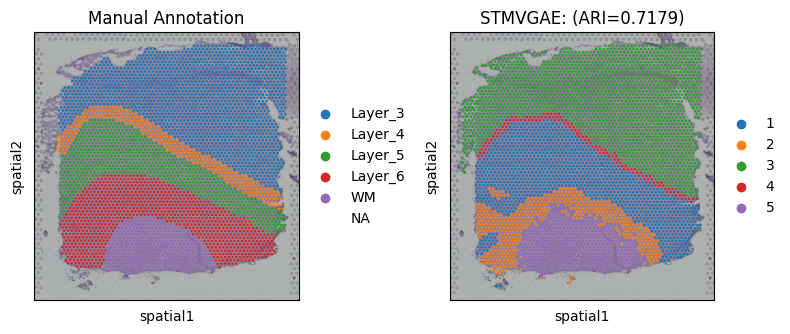

In [12]:
fig, axes = plt.subplots(1,2,figsize=(4*2, 4))
sc.pl.spatial(ann_data, color='Manual annotation', ax=axes[0], show=False)
sc.pl.spatial(ann_data, color='mclust', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('STMVGAE: (ARI=%.4f)' % mclust_ari)
plt.tight_layout()
plt.show()

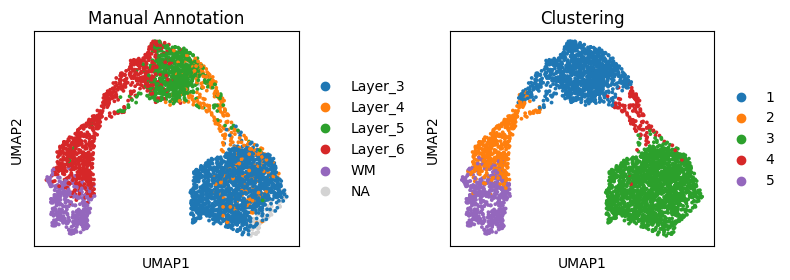

In [13]:
sc.pp.neighbors(ann_data, use_rep='z', metric='cosine',n_pcs=7)
sc.tl.umap(ann_data)

fig, axes = plt.subplots(1,2,figsize=(4*2, 3))
sc.pl.umap(ann_data, color='Manual annotation', ax=axes[0], show=False)
sc.pl.umap(ann_data, color='mclust', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering')

for ax in axes:
    ax.set_aspect(1)
    
plt.tight_layout()
plt.show()

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

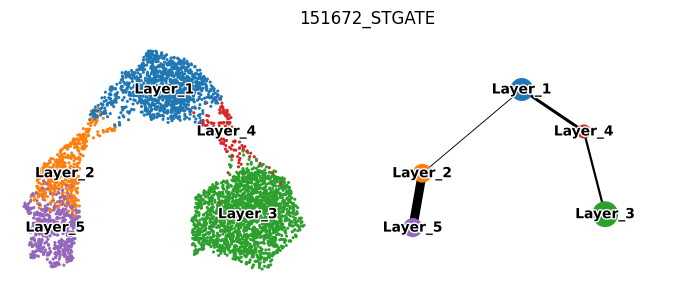

In [15]:
adata.obs['mclust_anno'] = adata.obs['mclust']
adata.obs['mclust_anno'].cat.categories = ['Layer_1','Layer_2','Layer_3','Layer_4','Layer_5']
 
sc.tl.paga(ann_data, groups='mclust_anno')

plt.rcParams["figure.figsize"] = (4, 3)
sc.pl.paga_compare(ann_data, legend_fontsize=10, frameon=False, size=20,
                   title=section_id + '_STGATE', legend_fontoutline=2, show=False)


In [17]:
pred = ann_data.obs['mclust_refine']
pred_path = os.path.join('consensus_cluster',section_id,'version_0','cluster_label.npy')
np.save(file=pred_path,arr = pred)

#consensus cluster

In [4]:
import glob
import itertools
from typing import List
from scipy.spatial import distance
from scipy.cluster import hierarchy


def labels_connectivity_mat(labels: np.ndarray):
    _labels = labels - np.min(labels)
    n_classes = np.unique(_labels)
    mat = np.zeros([labels.size, labels.size])
    for i in n_classes:
        indices = np.squeeze(np.where(_labels == i))  #将属于各个类的标签提取出来
        row_indices, col_indices = zip(*itertools.product(indices, indices))
        mat[row_indices, col_indices] = 1
    return mat


def consensus_matrix(labels_list: List[np.ndarray]):
    mat = 0
    for labels in labels_list:
        mat += labels_connectivity_mat(labels)
    return mat / float(len(labels_list))


def plot_consensus_map(cmat, method="average", return_linkage=True, **kwargs):
    row_linkage = hierarchy.linkage(distance.pdist(cmat), method=method)
    col_linkage = hierarchy.linkage(distance.pdist(cmat.T), method=method)
    figure = sns.clustermap(cmat, row_linkage=row_linkage, col_linkage=col_linkage, **kwargs)
    if return_linkage:
        return row_linkage, col_linkage, figure
    else:
        return figure


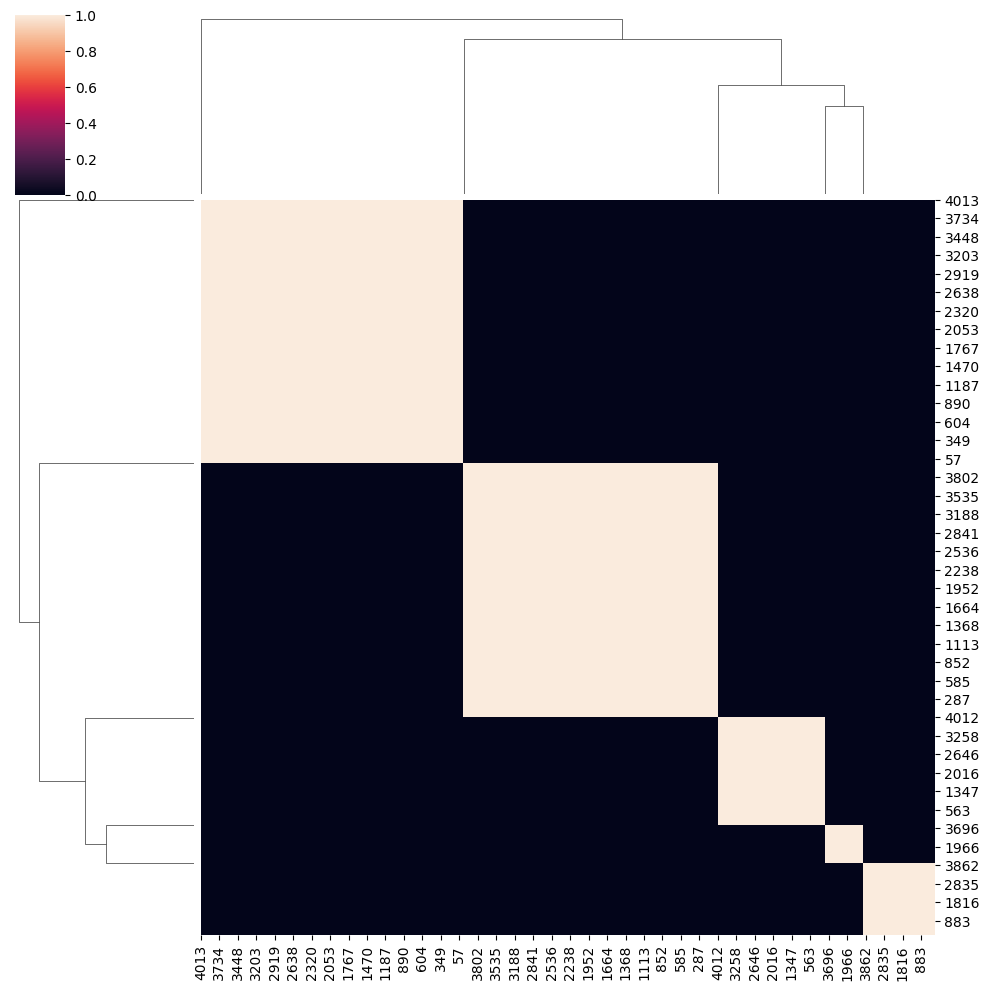

In [5]:
save_dir = 'consensus_cluster/151672'
name = "cluster_label.npy"
num_cluster = 5

sys.setrecursionlimit(100000)
label_files = glob.glob(save_dir + f"/version_*/{name}")
labels_list = list(map(lambda file: np.load(file), label_files))
cons_mat = consensus_matrix(labels_list)
row_linkage, _, figure = plot_consensus_map(cons_mat, return_linkage=True)  # 获取层次聚类结果和热度图
figure.savefig(os.path.join(save_dir, "consensus_clustering.png"), dpi=300)  # 保存图片
consensus_labels = hierarchy.cut_tree(row_linkage, num_cluster).squeeze()  # 得到y*
np.save(os.path.join(save_dir, "consensus_labels"), consensus_labels)

In [7]:
pred = np.load('consensus_cluster/151672/consensus_labels.npy')

DLPFC_dir = "../../dataset/DLPFC/"
section_id = "151672"
k = 5
ann_data = sc.read_visium(os.path.join(DLPFC_dir, section_id),
                          count_file=section_id + '_filtered_feature_bc_matrix.h5')
# load groud truth
ann_df = pd.read_csv(os.path.join(DLPFC_dir, section_id, section_id + "_truth.txt"),
                     sep="\t", header=None, index_col=0)
ann_df.columns = ["Manual annotation"]
ann_data.obs.loc[:, "Manual annotation"] = ann_df.loc[ann_data.obs_names, 'Manual annotation']
ann_data.var_names_make_unique()
print(ann_data)


indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
ground_truth = ann_data.obs["Manual annotation"].dropna()
ari = adjusted_rand_score(pred[indices], ground_truth[indices])
print("ari is: {:.4f}".format(ari))
nmi = normalized_mutual_info_score(pred[indices], ground_truth[indices])
print("nmi is: {:.4f}".format(nmi))
hs = homogeneity_score(pred[indices], ground_truth[indices])
print("hs is: {:.4f}".format(hs))
purity = purity_score(pred[indices], ground_truth[indices])
print("purity is: {:.4f}".format(purity))

AnnData object with n_obs × n_vars = 4015 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
ari is: 0.7220
nmi is: 0.7239
hs is: 0.7398
purity is: 0.8513


#SVGs

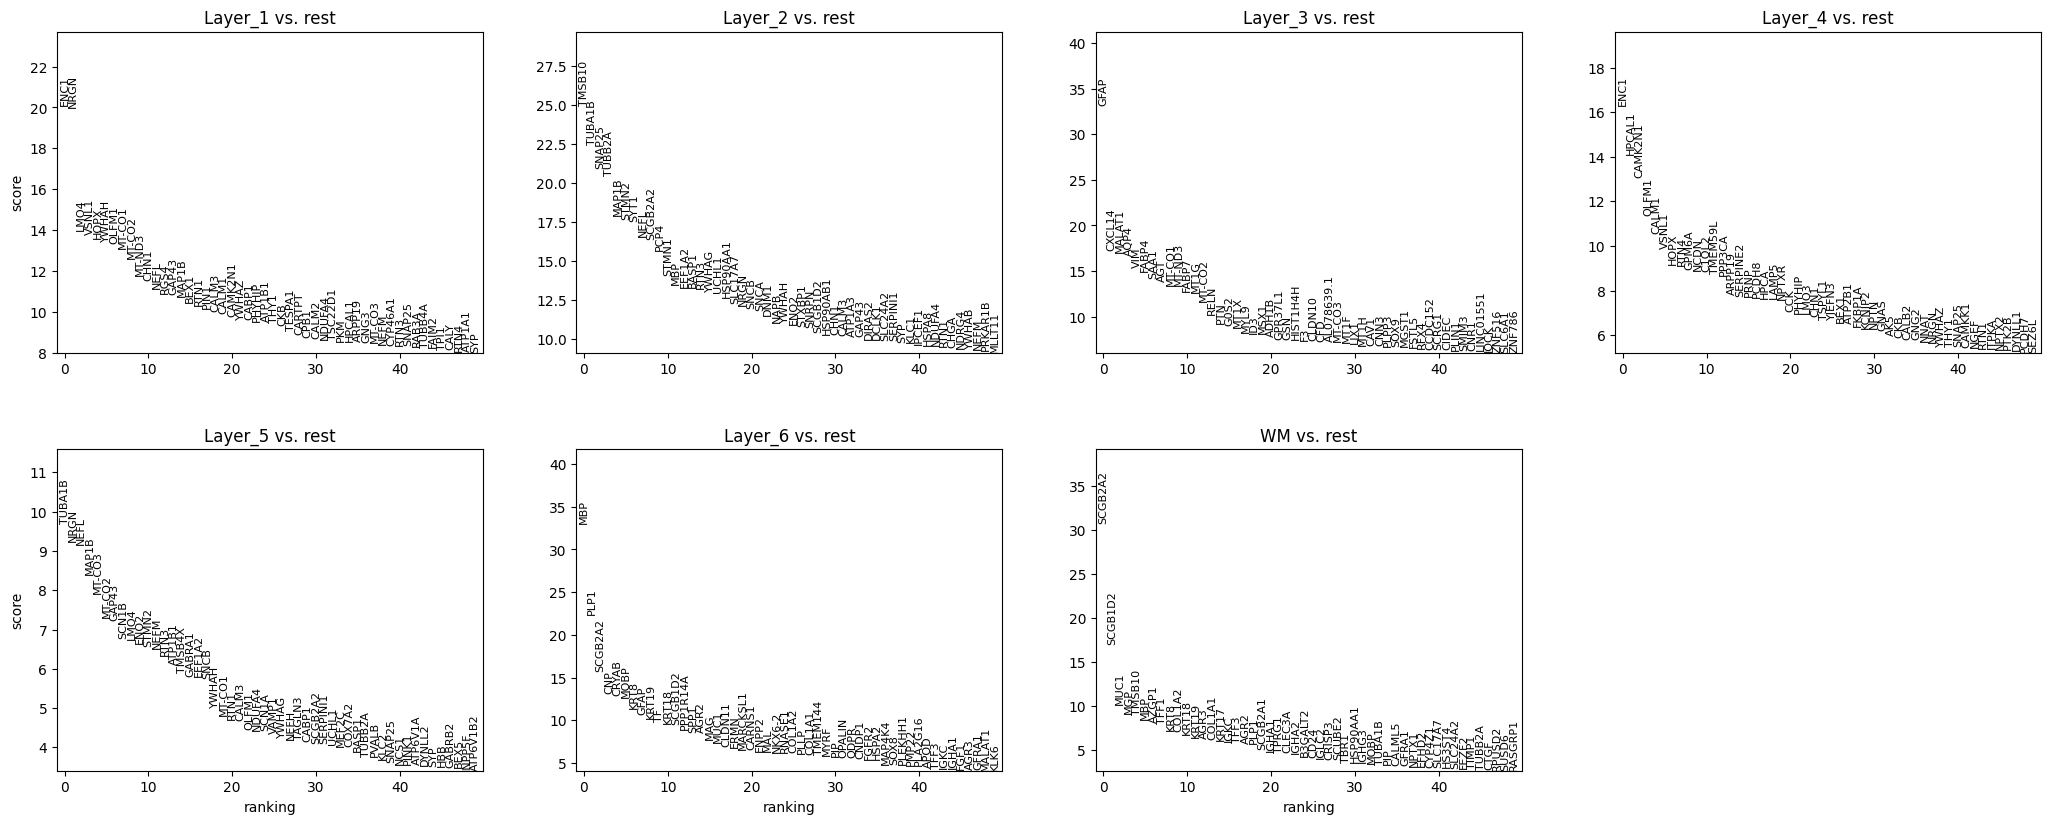

In [96]:
#rank_genes_groups
ann_data.obs['mclust_anno'] = ann_data.obs['mclust']
ann_data.obs['mclust_anno'].cat.categories = ['Layer_1','Layer_2','Layer_3','Layer_4','Layer_5','Layer_6','WM']

sc.tl.rank_genes_groups(ann_data, 'mclust_anno', method='t-test')
sc.pl.rank_genes_groups(ann_data, n_genes=50, sharey=False)

In [15]:
import SpaGCN as spg
import matplotlib.colors as clr

raw = sc.read_visium(os.path.join(DLPFC_dir, section_id),
                          count_file=section_id + '_filtered_feature_bc_matrix.h5')
raw.var_names_make_unique()
raw.obs["pred"]=ann_data.obs["mclust"].astype('category')
raw.obs["x_array"]=raw.obs["array_row"]
raw.obs["y_array"]=raw.obs["array_col"]
raw.obs["x_pixel"] = raw.obsm['spatial'][:,0]
raw.obs["y_pixel"] = raw.obsm['spatial'][:,1]
x_array = raw.obs["x_array"].tolist()
y_array = raw.obs["y_array"].tolist()
x_pixel = raw.obs["x_pixel"].tolist()
y_pixel = raw.obs["y_pixel"].tolist()
raw.X = (raw.X.A if issparse(raw.X) else raw.X)
raw.raw = raw
sc.pp.log1p(raw)

In [154]:
#Use domain 0 as an example
target=3
#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1
#Search radius such that each spot in the target domain has approximately 10 neighbors on average
adj_2d=spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
start, end= np.quantile(adj_2d[adj_2d!=0],q=0.001), np.quantile(adj_2d[adj_2d!=0],q=0.1)
r=spg.search_radius(target_cluster=target, cell_id=ann_data.obs.index.tolist(), x=x_array, y=y_array, pred=ann_data.obs["kmeans"].tolist(), start=start, end=end, num_min=10, num_max=200,  max_run=100)
#Detect neighboring domains
nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                   cell_id=raw.obs.index.tolist(), 
                                   x=raw.obs["x_array"].tolist(), 
                                   y=raw.obs["y_array"].tolist(), 
                                   pred=raw.obs["pred"].tolist(),
                                   radius=r,
                                   ratio=1/2)
nbr_domians=nbr_domians[0:3]
de_genes_info=spg.rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=nbr_domians, 
                                label_col="pred", 
                                adj_nbr=True, 
                                log=True)
#Filter genes
de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
filtered_info=de_genes_info
filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                            (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                            (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                            (filtered_info["fold_change"]>min_fold_change)]
filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
filtered_info["target_dmain"]=target
filtered_info["neighbors"]=str(nbr_domians)
print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [2.0, 18.384777069091797], num_nbr [8.663333333333334, 434.54]
Calculateing adj matrix using xy only...
recommended radius =  10.192388534545898 num_nbr=144.19
radius= 10.192388534545898 average number of neighbors for each spot is 144.19
 Cluster 3 has neighbors:
Dmain  0 :  17072
Dmain  2 :  15446
Dmain  4 :  477
SVGs for domain  3 : ['CAMK2N1', 'ENC1']


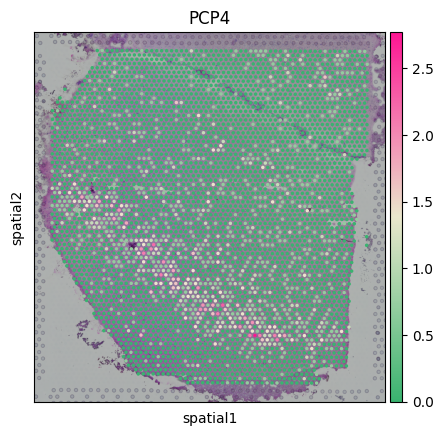

In [187]:
gene_list = ['PCP4']

color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
for g in gene_list:
#for g in filtered_info["genes"].tolist():
    raw.obs["exp"]=raw.X[:,raw.var.index==g]
    sc.pl.spatial(raw, img_key="hires",
              color="exp",
              title=g,
              color_map=color_self)

Add gene:  HPCAL1
Minus gene:  TUBA1B
Absolute mean change: 1.0226543
Number of non-target spots reduced to: 960
Meta gene is:  CALM1+HPCAL1-TUBA1B
Add gene:  TUBA1B
Minus gene:  PLP1
Absolute mean change: 1.3200057
Number of non-target spots reduced to: 482
Meta gene is:  CALM1+HPCAL1-TUBA1B+TUBA1B-PLP1
Add gene:  MALAT1
Minus gene:  TUBA1B
Absolute mean change: 1.685204
Number of non-target spots reduced to: 469
Meta gene is:  CALM1+HPCAL1-TUBA1B+TUBA1B-PLP1+MALAT1-TUBA1B


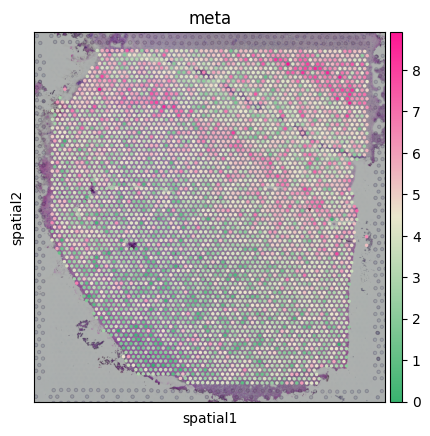

In [195]:
target=3
meta_name, meta_exp=spg.find_meta_gene(input_adata=raw,
                    pred=raw.obs["pred"].tolist(),
                    target_domain=target,
                    start_gene="CALM1",
                    mean_diff=0,
                    early_stop=True,
                    max_iter=3,
                    use_raw=False)

raw.obs["meta"]=meta_exp

raw.obs["exp"]=raw.obs["meta"]
sc.pl.spatial(raw, img_key="hires",
              color="exp",
              title='meta',
              color_map=color_self)

In [22]:
'''
#Plot meta gene
g="CXCL14"
raw.obs["exp"]=raw.X[:,raw.var.index==g]
ax=sc.pl.scatter(raw,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=g,color_map=color_self,show=False,size=100000/raw.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("SVGs_sample_results/"+g+".png", dpi=600)
plt.close()

raw.obs["exp"]=raw.obs["meta"]
ax=sc.pl.scatter(raw,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=meta_name,color_map=color_self,show=False,size=100000/raw.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("SVGs_sample_results/meta_gene.png", dpi=600)
plt.close()
'''